# Sparse tensors

A new functionality of Tensor Fox is the support for sparse tensors. Let $T \in \mathbb{R}^{I_1 \times \ldots \times I_L}$ ba a sparse tensor with *nnz* nonzero entries. The tensor is represented as a triple [*data, idxs, dims*], where *data* is an array of size $nnz$ such that *data[i]* is the $i$-th nonzero entry of $T$, with corresponding index *idxs[i]*. It is necessary to pass *idxs* also as an array, which will be of shape $nnz \times L$. Finally, we have that *dims* $= [I_1, \ldots, I_L]$. 

Below we create a fourth order sparse tensor $10 \times 10 \times 10 \times 10$ with only 6 nonzero entries. These entries are random and are located in random places of $T$. 

In [1]:
import numpy as np
import TensorFox as tfx
import matplotlib.pyplot as plt
from IPython.display import Image

## Small example

In [2]:
# Initial variables.
nnz = 6
n = 10
dims = (n, n, n, n)
L = len(dims)

# Create the nonzero values of T.
data = np.random.randn(nnz)

# Create indexes.
idxs = np.zeros((nnz, L), dtype=np.int64) 
for l in range(L):
    idxs[:, l] = np.random.randint(0, dims[l], size=(nnz))

# Define sparse tensor.
T = [data, idxs, dims]

Here we prefer the damped Gauss-Newton method to compute the CPD, but the Tensor Train CPD also works. We remark that it is not possible to use $\verb|tol| \_ \verb|mlsvd| = 0$ or $-1$ since these options doesn't perform compression and to work with large tensors as $T$ we must always to compress. In the case the user sets $\verb|display| = 3$ or $4$, the program computes only the error associated with the nonzero entries, otherwise we would face memory issues. 

In [3]:
class options:
    display = 3
    method = 'dGN'
    
R = 6
factors, output = tfx.cpd(T, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (10, 10, 10, 10) to (4, 6, 6, 6)
    Compression relative error = 0.000000e+00
-----------------------------------------------------------------------------------------------
Type of initialization: random
    Initial guess relative error = 3.389817e+01
-----------------------------------------------------------------------------------------------
Computing CPD
    Iteration | Rel error |  Step size  | Improvement | norm(grad) | Predicted error | # Inner iterations
        1     | 1.12e+01  |  2.39e-01   |  1.12e+01   |  1.05e+03  |    8.77e-06     |        3        
        2     | 3.87e+00  |  2.33e-01   |  7.34e+00   |  1.48e+02  |    1.41e-06     |        5        
        3     | 1.54e+00  |  2.50e-01   |  2.34e+00   |  2.13e+01  |    2.03e-05     |        5        
        4     | 1.02e+00  |  2.90e-01   |  5.17e-01   |  2.8

       85     | 2.33e-05  |  2.71e-05   |  1.89e-06   |  2.05e-05  |    6.09e-22     |        2        
       86     | 2.15e-05  |  2.50e-05   |  1.74e-06   |  1.89e-05  |    3.82e-22     |        2        
       87     | 1.99e-05  |  2.32e-05   |  1.61e-06   |  1.75e-05  |    2.39e-22     |        2        
       88     | 1.84e-05  |  2.14e-05   |  1.49e-06   |  1.62e-05  |    1.50e-22     |        2        
       89     | 1.71e-05  |  1.98e-05   |  1.38e-06   |  1.50e-05  |    9.40e-23     |        2        
       90     | 1.58e-05  |  1.83e-05   |  1.28e-06   |  1.39e-05  |    5.89e-23     |        2        
       91     | 1.46e-05  |  1.70e-05   |  1.18e-06   |  1.28e-05  |    3.69e-23     |        2        
       92     | 1.35e-05  |  1.57e-05   |  1.09e-06   |  1.19e-05  |    2.31e-23     |        2        
       93     | 1.25e-05  |  1.45e-05   |  1.01e-06   |  1.10e-05  |    1.45e-23     |        2        
       94     | 1.16e-05  |  1.34e-05   |  9.36e-07   |  1.02e-0

The relative error showed above only take in account the nonzero entries of $T$ (the same is valid for the compression error which is equal to zero in this example). The factor matrices of the decomposition may introduce small errors when approximating the zeros, and this small errors summed together does increase the actual error of the CPD. Thus the relative error showed above is a lower bound to the actual error, but usually it is close enough.

Since this is a small example we can put everything in dense format and verify what is the actual error. However this won't be possible for really large tensors. Regardless, the main point of the CPD is to approximate the nonzero entries, which is done.

In [4]:
# Generate the coordinate (dense) format of the approximation.
T_approx = tfx.cnv.cpd2tens(factors)

# Generate the dense format from the sparse representation.
T_dense = tfx.cnv.sparse2dense(data, idxs, dims)

# Compute the error.
np.linalg.norm(T_dense - T_approx)/np.linalg.norm(T_dense)

1.1556803949430619e-05

## Memory cost

There is a big reduction in memory cost when working with sparse representations. Below we show a graph with the maximum memory cost attained in the computation of the CPDs of sparse $n \times n \times n$ tensors (blue curve) vs. the cost to store these tensors in dense format. As we can see, the difference is substantial, Tensor Fox does avoid the intermediate memory explosion problem. For instance, the sparse approach requires $3648$ megabytes when $n = 30000$, whereas the dense approach requires approximately $205$ terabytes. 

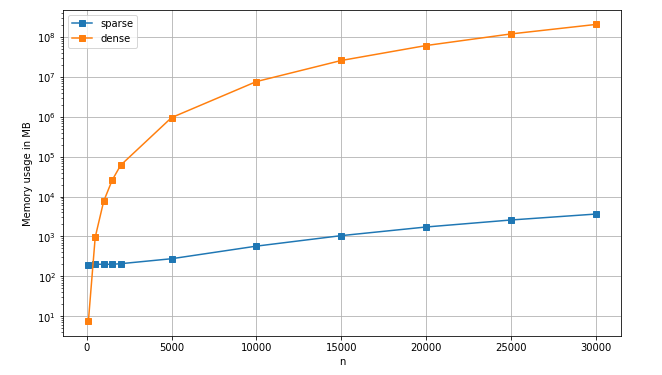

In [5]:
Image("sparse.png")

## Big example

We finish this lesson showing an example of a third order tensor with shape $10^6 \times 10^2 \times 10^2$, where all $nnz = 100$ nonzero entries forms a $100 \times 100$ matrix, with rank $r = 5$, within the diagonal of the tensor. This means this tensor can be regarded as a matrix embedded in a bigger structure.

In [5]:
# Initial variables.
r = 5
sqrt_nnz = 10
nnz = sqrt_nnz**2
dims = (1000000, nnz, nnz)
data = np.zeros(nnz)
idxs = np.zeros((nnz, 3), dtype=np.int64) 

# Create the nonzero values of T.
data = np.zeros(nnz)

# Generate a sqrt_nnz x sqrt_nnz matrix of rank r.
M = np.random.randn(sqrt_nnz, sqrt_nnz)
u, s, vt = np.linalg.svd(M)
s[r:] = 0
M = np.dot(u, np.dot(np.diag(s), vt))

# Create indexes and values for T.
t = 0
for i in range(sqrt_nnz):
    for j in range(sqrt_nnz):
        idxs[t, :] = [t, i, j]
        data[i*sqrt_nnz + j] = M[i, j]
        t += 1

# Define sparse tensor.
T = [data, idxs, dims]

In [6]:
# Let's compute a rank-5 CPD for T. This choice of rank seems to make sense since the tensor is a matrix in some sense.
R = 5
options.display = 1
factors, output = tfx.cpd(T, R, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (1000000, 100, 100) to (5, 5, 5)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
Final results
    Number of steps = 49
    Relative error = 0.8613199892895255
    Accuracy =  13.868 %


The reader may try to repeat the computation above a few times and note that the program is unable to find a good rank-$5$ fit for this tensor. Note that, although the computation of this CPD is fast (about $5$ seconds on my laptop), repeating this computation several times is much time consuming. A clever way to deal with this is to save the compressed tensor and run the several CPDs on this tensor, because we know that the compressed tensor is the core tensor of the MLSVD, and its shape is small ($5 \times 5 \times 5$ as we can see above). The CPD spend most of its time computing this compression. In fact, we can be even more clever and use the function **rank** to search the proper rank.

In [8]:
# Compute and save the core tensor of the MLSVD.
Tsize = np.linalg.norm(data)
options.display = 3
S, U, T1, sigmas, rel_error = tfx.cmpr.mlsvd(T, Tsize, R, options)
print('Compressing from', dims, 'to', S.shape)
print('Compression relative error = {:7e}'.format(rel_error))

Compressing from (1000000, 100, 100) to (5, 5, 5)
Compression relative error = 0.000000e+00


Start searching for rank
Stops at r = 25  or less
-----------------------------
Testing r = 6
rank(T) = 5
|T - T_approx|/|T| = 0.011608892469037846


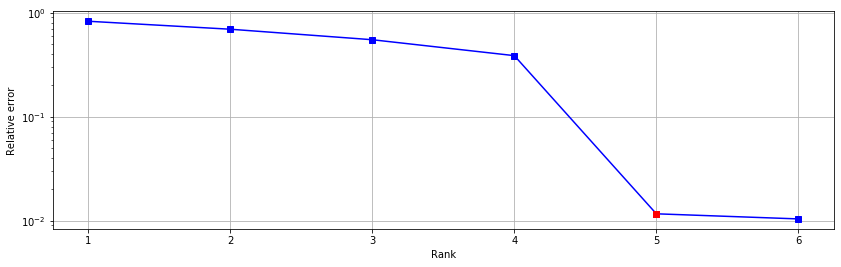

In [10]:
# Find the rank.
final_rank, error_per_rank = tfx.rank(S)

From the result above we can start to suspect that $R$ may be bigger than $5$, or this MLSVD is just too hard to handle. After some experimentation we conclude that $R = 8$ is a better choice. Note that $R$ is being used as a parameter for the MLSVD (more precisely, it is an upper bound for the multilinear rank), but the actual rank used to compute the CPD is another value.

Compressing from (1000000, 100, 100) to (8, 8, 8)
Compression relative error = 0.000000e+00

Start searching for rank
Stops at r = 64  or less
-----------------------------
Testing r = 34
rank(T) = 34
|T - T_approx|/|T| = 6.238809266691921e-05


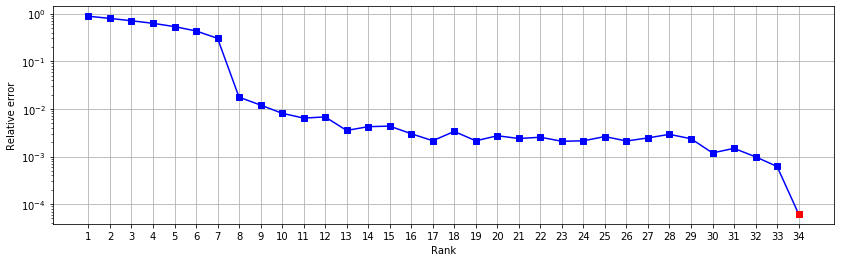

In [20]:
# Compute and save the core tensor of the MLSVD.
R = 8
S, U, T1, sigmas, rel_error = tfx.cmpr.mlsvd(T, Tsize, R, options)
print('Compressing from', dims, 'to', S.shape)
print('Compression relative error = {:7e}'.format(rel_error))
print()

# Find the rank.
final_rank, error_per_rank = tfx.rank(S, trials=10)

Final results
    Number of steps = 114
    Relative error = 0.0002612948756945937
    Accuracy =  99.97387 %


Parameters used
    initialization: random
    maximum of iterations: 200
    error tolerance: 1e-06
    steps size tolerance: 1e-06
    improvement tolerance: 1e-06
    gradient norm tolerance: 1e-06
    inner algorithm parameters:
        method: conjugate gradient dynamic/random
        cg factor: 1
        cg tolerance: 1e-16



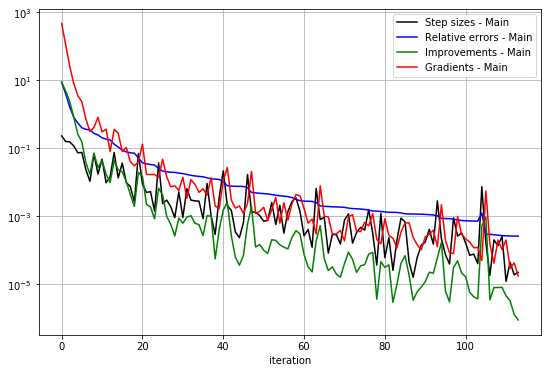

In [24]:
# Now we compute the CPD for the right rank (in this case it is R = 34). We remark that still may be necessary to repeat 
# this computation a few times until a good fit is found. For that reason we prefer to use the function foxit 
#(introduced in lesson 9).
R = final_rank
factors, output = tfx.foxit(S, R, bestof=15)

In [26]:
# Finaly, compute the error |T - (U1, U2, U3)*S| / |T| over the nonzero entries of T.
S1 = tfx.cnv.unfold(S, 1)
rel_error = tfx.mlinalg.compute_error(T, Tsize, S, U, dims)
print('Relative Error =', rel_error)

Relative Error = 0.0
